# **Analysis of Most Streamed Spotify Songs**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spotify_streaming_df = pd.read_csv('data/spotify_most_streamed_songs.csv')
spotify_streaming_df

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cover_url
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,B,Major,80,89,83,31,0,8,4,Not Found
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,C#,Major,71,61,74,7,0,10,4,https://i.scdn.co/image/ab67616d0000b2730656d5...
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,F,Major,51,32,53,17,0,31,6,https://i.scdn.co/image/ab67616d0000b273e85259...
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,A,Major,55,58,72,11,0,11,15,https://i.scdn.co/image/ab67616d0000b273e787cf...
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,A,Minor,65,23,80,14,63,11,6,https://i.scdn.co/image/ab67616d0000b273ab5c9c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,Selena Gomez,1,2022,11,3,953,0,91473363,61,...,A,Major,60,24,39,57,0,8,3,https://i.scdn.co/image/ab67616d0000b2730f5397...
949,Bigger Than The Whole Sky,Taylor Swift,1,2022,10,21,1180,0,121871870,4,...,F#,Major,42,7,24,83,1,12,6,https://i.scdn.co/image/ab67616d0000b273e0b60c...
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022,11,3,573,0,73513683,2,...,C#,Major,80,81,67,4,0,8,6,Not Found
951,En La De Ella,"Feid, Sech, Jhayco",3,2022,10,20,1320,0,133895612,29,...,C#,Major,82,67,77,8,0,12,5,Not Found


Feature descriptions from the kaggle posting:

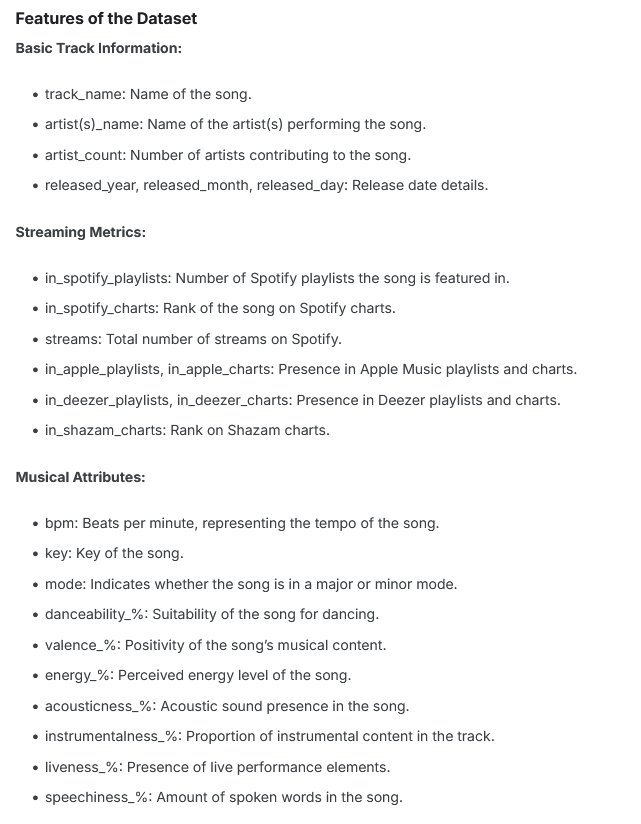

# **Cleaning the Data**

## **The Dirty Data**

## Visual Inspection of the Data

The cover_url column contains the urls to each song's album art. This largely irrelevant for our purposes, so it's ok to drop.

The in_spotify_charts, in_deezer_charts, in_apple_charts, and in_shazam_charts columns are hard to interpret because it's not clear if higher numbers are better ranks or if lower numbers are better ranks. The Kaggle posting doesn't offer much insight into this situation, so the columns are basically meaningless and we won't use them. Since we're not going to use them, we may as well drop them.

In [3]:
spotify_streaming_df.drop(columns=['cover_url', 'in_spotify_charts', 'in_apple_charts', 'in_deezer_charts', 'in_shazam_charts'], inplace=True)

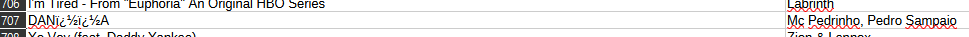

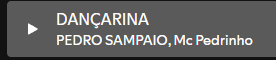

As seen above, some of the track/artist names with asian characters or accent marks are not showing properly likely due to some encoding issue encountered before the data was posted on Kaggle. There's not much we can do about it, but we aren't referencing tracks or artists by name very much, so it won't be an issue.

## Programmatic Inspection of the Data

Now let's check the datatypes of each column for any potential problems.

In [4]:
spotify_streaming_df.dtypes

track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
streams                 object
in_apple_playlists       int64
in_deezer_playlists     object
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object

There are two columns whose datatypes need to be corrected as shown in the table below:

| Column | Description |
| ------ | ----------- |
| streams | The number of streams the songs has on spotify |
| in_deezer_playlists | The number of deezer playlists the song is in |

The data in these columns are strings, but would be way more useful as ints.

In [5]:
# find num NA in each column
print(f'Col{22*" "}Number of NA')
print(40 * '-')
for col in spotify_streaming_df.columns:
  print(f'{col}{(25 - len(col)) * " "}{len(spotify_streaming_df[spotify_streaming_df[col].isna()])}')

print()
print(f'Total number of rows: {len(spotify_streaming_df)}')

Col                      Number of NA
----------------------------------------
track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
streams                  0
in_apple_playlists       0
in_deezer_playlists      0
bpm                      0
key                      95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0

Total number of rows: 953


The only column with missing values is key where the number of missing values is 9.97% of the total data.

There are too many missing values to simply drop those rows.

It might be possible to obtain the missing keys from the Spotify API if we need them later.

In [6]:
# check for duplicate tracks
num_tracks = len(spotify_streaming_df['track_name'])
num_unique_tracks = len(spotify_streaming_df['track_name'].unique())
dupe_check = "dupes detected" if num_tracks != num_unique_tracks else "no dupes detected"

print(dupe_check)
print(f'# of dupes: {num_tracks - num_unique_tracks}')

dupes detected
# of dupes: 10


It would appear that there are some tracks which share the same name.

In [7]:
dupes = spotify_streaming_df['track_name'].mode()
dupes

0                           About Damn Time
1                                  Daylight
2                               Die For You
3                                   Flowers
4    Let It Snow! Let It Snow! Let It Snow!
5                                  Miss You
6                                      Numb
7                                      SNAP
8                          SPIT IN MY FACE!
9                            Take My Breath
Name: track_name, dtype: object

The above are the 10 duplicate tracks.

In [8]:
spotify_streaming_df[spotify_streaming_df['track_name'] == 'About Damn Time']

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
372,About Damn Time,Lizzo,1,2022,7,15,2332,723894473,0,25,109,A#,Minor,84,72,74,10,0,34,7
764,About Damn Time,Lizzo,1,2022,4,14,9021,723894473,242,272,109,A#,Minor,84,72,74,10,0,34,7


In [9]:
spotify_streaming_df[spotify_streaming_df['track_name'] == 'Take My Breath']

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
512,Take My Breath,The Weeknd,1,2021,8,6,2597,130655803,17,38,121,A#,Minor,70,35,77,1,0,26,4
616,Take My Breath,The Weeknd,1,2021,8,6,6392,432702334,174,344,121,G#,Major,75,53,74,2,0,11,5


It looks like some of the duplicate tracks aren't necessarily duplicates as seen with Take My Breath by The Weeknd as the key, mode, and a few other traits differ.

However, in the case of About Damn Time by Lizzo, it looks like the only thing different between the two tracks is the release date and the metrics related to streams, charts, and playlists.

In order to see how many of the 10 dupes are "true dupes", let's check if they share more than just the track name.

In [10]:
dupe_traits = [
    'artist(s)_name',
    'artist_count',
    'key',
    'bpm',
    'mode',
    'danceability_%',
    'valence_%',
    'energy_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]

true_dupes = 0
for dupe in dupes:
  dupe_data = spotify_streaming_df[spotify_streaming_df['track_name'] == dupe]

  track1 = dupe_data.iloc[0]
  track2 = dupe_data.iloc[1]

  if track1[dupe_traits].eq(track2[dupe_traits]).all():
    print(f'True dupe detected: {track1["track_name"]}')
    true_dupes += 1

print(f'# of true dupes: {true_dupes}')

True dupe detected: About Damn Time
# of true dupes: 1


Looks like About Damn Time by Lizzo is the only real dupe in the dataset. Since it's only 1 track of 953, leaving it in won't cause any serious problems.

In [11]:
spotify_streaming_df[['released_year', 'released_month', 'released_day']]

,released_year,released_month,released_day
0,2023,7,14
1,2023,3,23
2,2023,6,30
3,2019,8,23
4,2023,5,18
...,...,...,...
948,2022,11,3
949,2022,10,21
950,2022,11,3
951,2022,10,20


The released_year, released_month, and released_day columns are good, but they would be even better as one column containing datetimes.

## **Getting the Grime Off (Actually Cleaning the Data)**

The first order of business is to convert the problematic columns (in_deezer_playlists and streams) from strings to ints.

In [12]:
spotify_streaming_df['in_deezer_playlists'] = spotify_streaming_df['in_deezer_playlists'].str.replace(',', '').astype(int)

Next is the streams column which represents each song's number of streams on Spotify. The reason it fails to cast normally is due to a particular row having a malformed data point.

In [13]:
spotify_streaming_df[spotify_streaming_df['streams'].apply(lambda x: not(x.isdigit()))]

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
574,Love Grows (Where My Rosemary Goes),Edison Lighthouse,1,1970,1,1,2877,BPM110KeyAModeMajorDanceability53Valence75Ener...,16,54,110,A,Major,53,75,69,7,0,17,3


Since it is a single row of 953 (0.105% of the data), it is fine to remove.

Once it is removed, the conversion is successful.

In [14]:
spotify_streaming_df.drop(574, inplace=True)
spotify_streaming_df['streams'] = spotify_streaming_df['streams'].astype(int)

Combining the released_year, released_month, and released_day columns into a single release_date column is pretty straightforward.

In [15]:
col_mapping = {
    'released_year': 'year',
    'released_month': 'month',
    'released_day': 'day'
}

release_dates = pd.to_datetime(spotify_streaming_df.rename(columns=col_mapping)[['year', 'month', 'day']])
spotify_streaming_df.insert(3, 'release_date', release_dates)
spotify_streaming_df.drop(columns=['released_year', 'released_month', 'released_day'], inplace=True)

Now lets see the data after all the cleaning is done.

In [16]:
spotify_streaming_df

,track_name,artist(s)_name,artist_count,release_date,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023-07-14,553,141381703,43,45,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023-03-23,1474,133716286,48,58,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023-06-30,1397,140003974,94,91,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019-08-23,7858,800840817,116,125,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023-05-18,3133,303236322,84,87,144,A,Minor,65,23,80,14,63,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,Selena Gomez,1,2022-11-03,953,91473363,61,37,144,A,Major,60,24,39,57,0,8,3
949,Bigger Than The Whole Sky,Taylor Swift,1,2022-10-21,1180,121871870,4,8,166,F#,Major,42,7,24,83,1,12,6
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022-11-03,573,73513683,2,7,92,C#,Major,80,81,67,4,0,8,6
951,En La De Ella,"Feid, Sech, Jhayco",3,2022-10-20,1320,133895612,29,17,97,C#,Major,82,67,77,8,0,12,5


# **HYPOTHESIS NUMBER 1: Danceability and Energy of Music Composed in Major and Minor Nodes**


**PART 1: Building Our Hypothesis**

A common popular myth in music composition is that music in minor mode tend to be sadder and more moody. We would like to test if there is actually any meaningful correlation between minor modes and the music actually being sadder. This can be done on our data set in the form of looking at how songs in major and minor keys vary in danceability and energy and see if there is a statistically significant difference in these two categories. We can now propose a null and alternative hypothesis for both energy and danceability:

**ENERGY ANALYSIS:**

$H_{0}$ : There is no difference between the distribution of energy level of a song and whether or not it is in a minor mode versus major mode.

$H_{A}$ : There is a meaningful difference between the distribution of energy level of a song and whether or not it is in a minor mode versus major mode.


**DANCEABILITY ANALYSIS:**

$H_{0}$ : There is no difference between the distribution of danceability of a song and whether or not it is in a minor mode versus major mode.

$H_{A}$ : There is a meaningful difference between the distribution of danceability of a song and whether or not it is in a minor mode versus major mode.

We will set the alpha level to be the standard 0.05 and compare our obtained values to this in order to assess statistical significance.

<br>
**Part 2: Data Analysis and Picking our Test to Use**

From our dataset we can see that major and minor modes are two qualitative data points and can be viewed as categorical for when we assess. As for danceability and energy level, both are given as percentages. We can first look at the distribution of both categories overall and then break them into a couple discrete categories to group them by judging by how the distribution of both comes out. We would like to create the following categories for both danceability and energy; High, Medium, Low. The way we will do this is to look at what percentage of the data falls below the 33 percentile and call this Low Energy/Danceability, data between the 33 and 66 percentile as Medium Energy/Danceability and between 66 and 100 percentile as High Energy/Danceability. The code for calculating these is provided below:

In [17]:
spotify_streaming_df['danceability_%'].describe(percentiles=[.33, .66, 1.0])

count    952.000000
mean      66.984244
std       14.631282
min       23.000000
33%       61.000000
50%       69.000000
66%       75.000000
100%      96.000000
max       96.000000
Name: danceability_%, dtype: float64

In [18]:
spotify_streaming_df['energy_%'].describe(percentiles=[.33, .66, 1.0])

count    952.000000
mean      64.274160
std       16.558517
min        9.000000
33%       58.000000
50%       66.000000
66%       73.000000
100%      97.000000
max       97.000000
Name: energy_%, dtype: float64

From our calculations above, we can see break down both categories by the following categories and classifications:


**Danceability Breakdown**

| Category | Danceability% In Range |
|---|---|
| Low | 0 - 61 |
| Medium | 61-75 |
| High | 75-96 |

<br>

**Energy Breakdown**



| Category | Energy% In Range |
|---|---|
| Low | 0 - 58 |
| Medium | 58-73 |
| High | 73-97 |
<br>

By making these two values into categorical groups, we now have our independent variable, Major vs Minor Mode, as a categorical value and our dependent variables, Energy % and Danceability % as categorical values as well. Thus the most appropriate statistical test for our data will be **Chi Square Tests** to see if major and minor modes result in different categorical distributions for each dependent variable or not. Now we are ready to break up our data into the aforementioned groups and then analyze the data.

**Part 3: Processing Data and Graphing Outcome**

Lets go ahead and clean up our data so it is groups by major and minor modes and how each break down into the distinct categories:

In [19]:
hypo_df = spotify_streaming_df.copy()
def categorize_energy(energy):
    if energy <= 58:
        return 'Low'
    elif energy <= 73:
        return 'Medium'
    else: return 'High'

hypo_df['energy_%'] = hypo_df['energy_%'].apply(categorize_energy)
def categorize_energy(danceability):
    if danceability <= 61:
        return 'Low'
    elif danceability <= 75:
        return 'Medium'
    else: return 'High'

hypo_df['danceability_%'] = hypo_df['danceability_%'].apply(categorize_energy)
energy_breakdown = hypo_df[['mode', 'energy_%']].groupby(['mode', 'energy_%']).size().reset_index(name='counts')
energy_breakdown = energy_breakdown.pivot(index='mode', columns='energy_%', values='counts')
energy_breakdown

energy_%,High,Low,Medium
mode,,,
Major,176,200,173
Minor,135,123,145


In [20]:
danceability_breakdown = hypo_df[['mode', 'danceability_%']].groupby(['mode', 'danceability_%']).size().reset_index(name='counts')
danceability_breakdown = danceability_breakdown.pivot(index='mode', columns='danceability_%', values='counts')
danceability_breakdown

danceability_%,High,Low,Medium
mode,,,
Major,151,219,179
Minor,155,109,139


Now that we have the data broken down into the distinct groups, we can now graph each one to see how the distributions looks. Each graph specifically looks at the distribution of high,medium, and low category songs for major and minor modes. The first graph focuses on mode distributions for energy level and the second is for danceability:

Text(0, 0.5, 'Count')

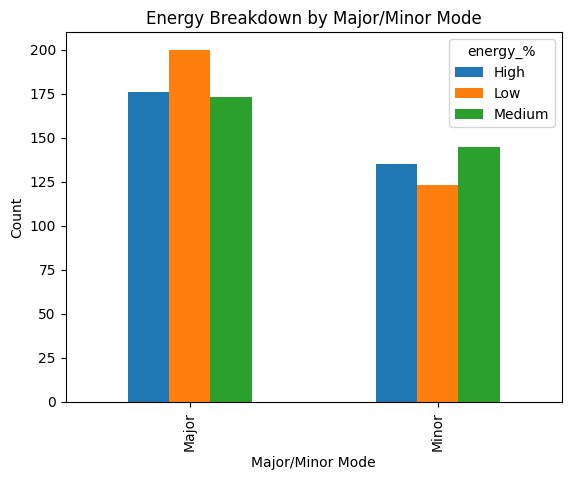

In [21]:
energy_graph = energy_breakdown.plot(kind='bar')
energy_graph.set_title('Energy Breakdown by Major/Minor Mode')
energy_graph.set_xlabel('Major/Minor Mode')
energy_graph.set_ylabel('Count')

Text(0.5, 0, 'Major/Minor Mode')

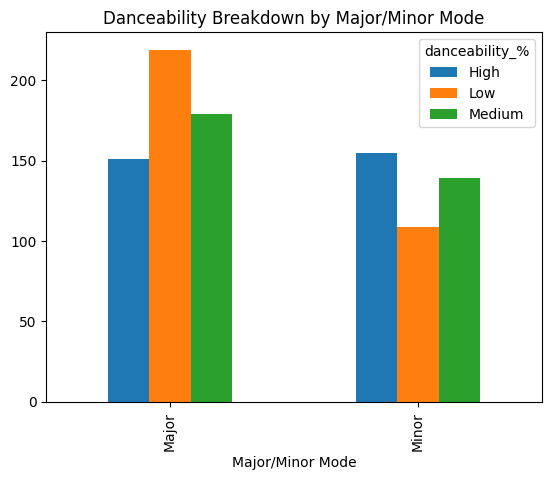

In [22]:
danceability_breakdown_graph = danceability_breakdown.plot(kind='bar')
danceability_breakdown_graph.set_title('Danceability Breakdown by Major/Minor Mode')
danceability_breakdown_graph.set_xlabel('Major/Minor Mode')

From our graphs above, we can do some quick general analysis and see that the distribution of energy by mode looks relatively similar but the danceability distribution looks significantly different. We can now verify this by doing chi square tests for both energy and danceability. This process first involves creating contingency tables for each and then conducting the chi square test on each:

In [23]:
from scipy import stats


In [24]:
contingency_table = pd.crosstab(hypo_df['mode'], hypo_df['danceability_%'])
contingency_table
stats.chi2_contingency(contingency_table)

Chi2ContingencyResult(statistic=np.float64(20.054907162567982), pvalue=np.float64(4.417049254558972e-05), dof=2, expected_freq=array([[176.46428571, 189.1512605 , 183.38445378],
       [129.53571429, 138.8487395 , 134.61554622]]))

In [25]:
contingency_table_energy = pd.crosstab(hypo_df['mode'], hypo_df['energy_%'])
contingency_table_energy
stats.chi2_contingency(contingency_table_energy)

Chi2ContingencyResult(statistic=np.float64(3.9282250308555486), pvalue=np.float64(0.1402803280146365), dof=2, expected_freq=array([[179.34768908, 186.26785714, 183.38445378],
       [131.65231092, 136.73214286, 134.61554622]]))

**PART 4: Conclusion**

From our Chi Squared tests we can see that our initial observations of the graphs did in fact prove to be correct. The P-Value of the distribution of Major/Minor modes for danceability is 0.00004417 which is far below our set alpha of 0.05 and thus we **REJECT** our null hypothesis and accept our alternate hypothesis that there is a significant difference between major and minor modes and the danceability levels of songs within those modes. In this case it is as we expected and the danceability is lower for minor modes.

On the other hand, the Chi Squared Analysis returned for Major/Minor modes vs Energy distribution gave back a P-Value of 0.14 which is not below our alpha of 0.05 and we **fail** to reject our null hypothesis and conclude that there is no significant difference of energy distribution of songs for major vs minor modes.


## **Hypothesis Number 2: BPM and its Correlation to Popularity**

Looking at the dataframe, I would like to test the beats per minute (bpm) in relation to its popularity:

Since we do not know if the bpm is normally distributed we can check by graphing the bpm


So now lets start with our hypothesis:

* Null Hypothesis: BPM has no effect on the amount of streams of a song

* Alternative Hypothesis: BPM has an effect on the amount of streams of a song


Let us create a visualization for our hypothesis:

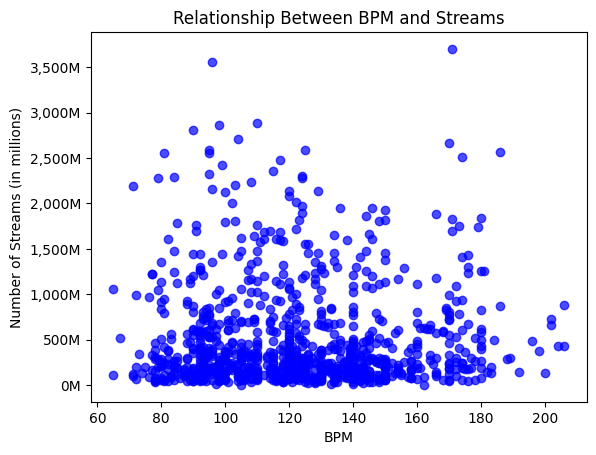

In [26]:
from matplotlib.ticker import FuncFormatter

plt.scatter(spotify_streaming_df['bpm'],spotify_streaming_df['streams'], color='blue',alpha=.7)

plt.title('Relationship Between BPM and Streams')
plt.xlabel('BPM')
plt.ylabel('Number of Streams (in millions)')

def millions(x, pos):
    return f'{int(x * 1e-6):,}M'

f = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(f)

plt.show()

Now that we have visualized the data, lets conduct a pearson coefficient test for our hypothesis

In [27]:
import scipy.stats as stats

coefficient,pvalue = stats.pearsonr(spotify_streaming_df['bpm'], spotify_streaming_df['streams'])

print(f'The Pearson coefficient is {coefficient} \n and the pvalue is: {pvalue}')

The Pearson coefficient is -0.0024379081382717837 
 and the pvalue is: 0.9401178701572729


As we can see the pearson value is close to 0, and the pvalue, .95 is greater than .05
So therefore the data is insignificant and we fail to reject the null hypothesis.
The BPM of a song has no effect on the amount of streams it has.

# **Hypothesis Number 3: Valence and the Effect On Streams**

We wish to determine if a track's <i>valence</i> has an effect on its respective number of streams. Valence refers to the musical positiveness or emotional quality of a track. Higher values denote a more cheerful and upbeat sound while lower values denote a more sad and somber sound. Let's assume a confidence level $\alpha$ of 0.05. <br>

Here is our hypotheses:

- $H$<sub>0</sub>: Valence does not affect the number of streams a track receives. <br>

- $H$<sub>A</sub>: Valence has an effect on the number of streams a track receives. <br>

In the dataset, the valence (in percentage) can range from 0 to 100. Let's create a new column that categorizes the track based on three valence groups: low, medium, and high. We can determine the groups by using tertiles, which divides the data into three equal parts, corresponding to the 33rd and 67th percentiles.

- Low Valence: Below 33rd Percentile

- Medium Valence: Between 33rd and 67th Percentile

- High Valence: Above 67th Percentile

We can determine tertiles as follows:

In [28]:
temp_spotify_stream_df = spotify_streaming_df.copy()
tertiles = temp_spotify_stream_df['valence_%'].quantile([0.33, 0.67])

for t, p in zip(tertiles, ["33rd Percentile", "67th Percentile"]):
    print(f"{p}: {t}")


33rd Percentile: 40.0
67th Percentile: 63.0


Given this we'll define low valence with ranges from 0-40, medium valence with ranges from 41-63, and high valence with ranges 64-100.

Let's now categorize each track into one of the three groups accordingly

In [29]:
# A function that will be applied to each track and categorize it into the three aforementioned groups accordingly
def categorize_valence(valence):
    if valence <= 40:
        return 'Low'
    elif valence <= 63:
        return 'Medium'
    else: return 'High'

temp_spotify_stream_df['valence_level'] = temp_spotify_stream_df['valence_%'].apply(categorize_valence)


Before we can conduct any statistical or hypothesis testing, we must first determine if the data (i.e. the number of streams) is normally distributed and pick a test accordingly. We can easily accomplish this by creating a histogram for each valence level and visually inspecting if it has a bell-shaped curve.

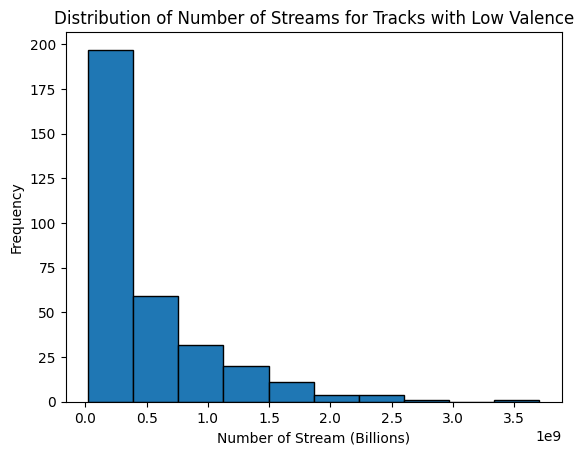

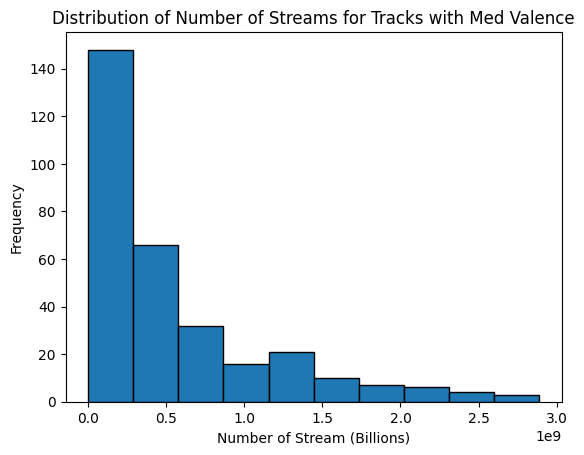

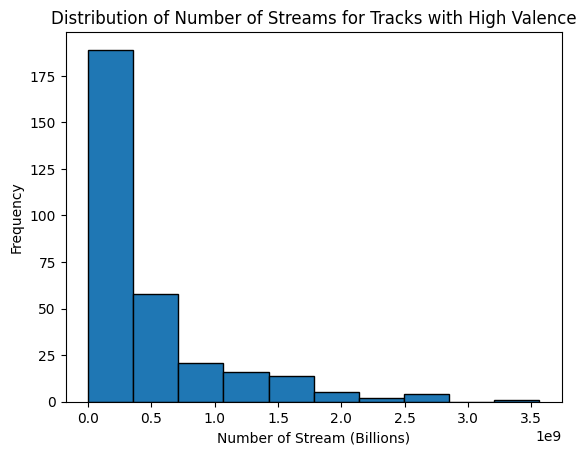

In [30]:
x = temp_spotify_stream_df.groupby('valence_level')
low = x.get_group('Low')
medium = x.get_group('Medium')
high = x.get_group('High')
groups = [low, medium, high]

for g, valence_level in zip(groups, ['Low', 'Med', 'High']):
    plt.hist(g['streams'], edgecolor= "black")
    plt.xlabel("Number of Stream (Billions)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Number of Streams for Tracks with {valence_level} Valence")
    plt.show()

Observe that the distribution of the number of streams for each valence level does NOT follow a normal distribution. Since normality assumptions are not met, we must use a non-parametric hypothesis test. Furthermore, since we have three samples with a decent amount of outliers, the Mood's median test would be the most appropriate to apply here as it's more robust to outliers compared to Kruskal-Wallis test (although it is generally stronger than the former).

Now let's calculate the p-value:

In [31]:
import scipy.stats as stats
import numpy as np
p_value = stats.median_test(low['streams'], medium['streams'], high['streams']).pvalue
p_value.item()

0.37315487021822763

Because the P-value (0.333) is significantly higher than $\alpha$ = 0.05, we fail to reject the null hypothesis. This also implies that there is little evidence to suggest that a track's level of valence has an effect on its respective number of streams and that these results are likely to occur under the conditions assumed by the null hypothesis.

Now let's visualize the distribution of data for each valence level:

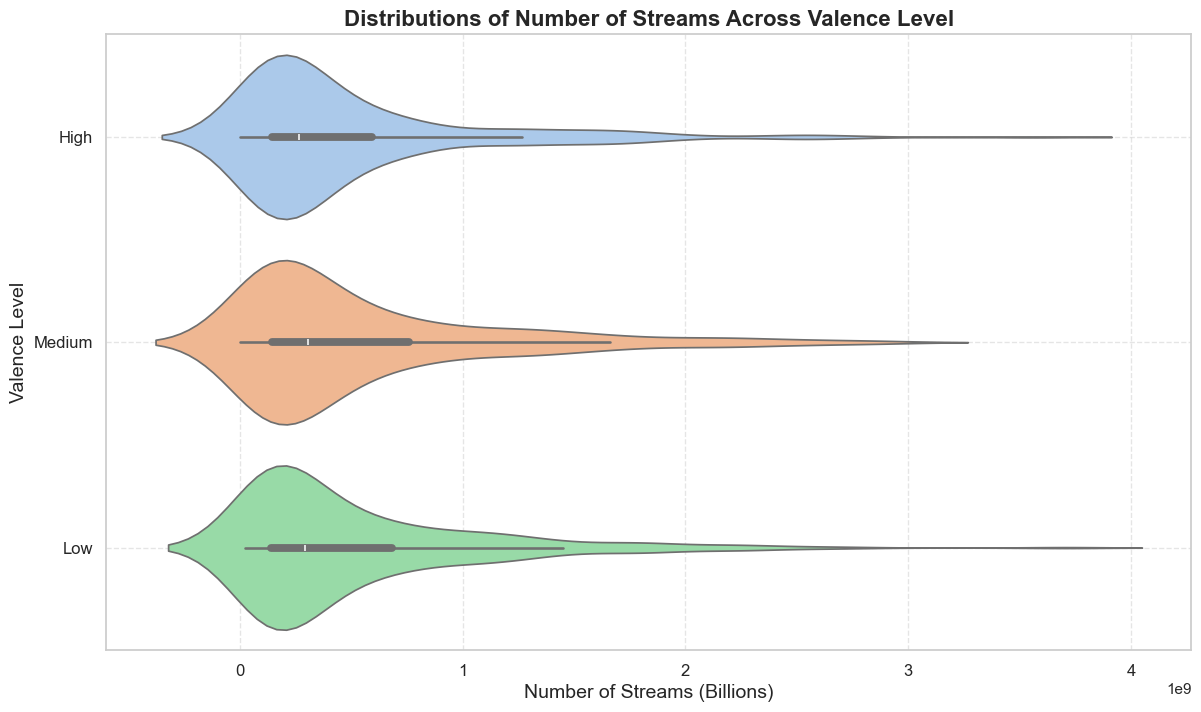

Valence Level,Mean (in Hundred Millions),Median (in Hundred Millions)
Low,5.07,2.93
Medium,5.54,3.06
High,4.82,2.65


In [33]:
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 8))
sns.violinplot(y='valence_level', x='streams', hue ="valence_level",data=temp_spotify_stream_df, palette="pastel", legend=False)
plt.xlabel("Number of Streams (Billions)", fontsize=14)
plt.ylabel("Valence Level", fontsize=14)
plt.title("Distributions of Number of Streams Across Valence Level", fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

def rounding(num):
    return f"{round(num/100000000, 2)}".rstrip("0")

data = {'Valence Level': ['Low', 'Medium', 'High'], 'Mean (in Hundred Millions)': [rounding(low['streams'].mean()), rounding(medium['streams'].mean()), rounding(high['streams'].mean())],
        'Median (in Hundred Millions)':[rounding(low['streams'].median()), rounding(medium['streams'].median()), rounding(high['streams'].median())]}
statistics = pd.DataFrame(data)
statistics.style.hide(axis="index")

From the violin plot, we can see that there is a relatively similar distribution of the number of streams across each valence level. There are a few differences in the upper and inner quartiles, interquartile ranges (especially between Medium/Low and High valence level), and outliers. However, the most notable similarity is the median and mean number of streams, which ranges from 2.65 to 3.06 and 4.82 to 5.54 hundred million respectively. The small differences in the distribution implies that there is an inconclusive amount of evidence to suggest that the valence level has an effect on a track's number of streams, aligning with our previous decision to fail to reject the null hypothesis.